## Problem Statement:
Dataset: Computer Hardware Dataset

The aim is to estimate the relative CPU performance of a computer hardware dataset. 

## Data Set Information:

**Attribute Information:**

1. vendor name: 30
(adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec,
dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson,
microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry,
sratus, wang)
2. Model Name: many unique symbols
3. MYCT: machine cycle time in nanoseconds (integer)
4. MMIN: minimum main memory in kilobytes (integer)
5. MMAX: maximum main memory in kilobytes (integer)
6. CACH: cache memory in kilobytes (integer)
7. CHMIN: minimum channels in units (integer)
8. CHMAX: maximum channels in units (integer)
9. PRP: published relative performance (integer)
10. ERP: estimated relative performance from the original article (integer)

In [281]:
# Importing python libraries

import numpy as np # for mathematical operations
import pandas as pd # to manage the dataset
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from numpy import mean
from numpy import absolute
from numpy import sqrt

# For visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [282]:
# import the dataset
input_file = "machine.data"
df = pd.read_csv(input_file, header = None)

## 1. Data Visualization and Exploration

In [283]:
#1.1 printing first 5 rows of dataset
df.head(2)


,0,1,2,3,4,5,6,7,8,9
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253


In [284]:
# printing shape of the dataset
df.shape

(209, 10)

In [285]:
# Renaming columns of dataframe
col_names = ['Vendor Name','Model Name', 'Machine Cycle Time', 'Min Memory', 'MAX Memory', 'Cache memory'
             ,'MIN Channel', 'MAX Channel', 'Published RP', 'Estimated RP' ]
df.columns = col_names
#Printed first 2 rows of dataset, all features are present.
df.head(2)

,Vendor Name,Model Name,Machine Cycle Time,Min Memory,MAX Memory,Cache memory,MIN Channel,MAX Channel,Published RP,Estimated RP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253


In [286]:
#1.2 Class imbalance : Below outputs shows that data is not uniformly distributed as difference between mean and median is significant.
df.describe()

,Machine Cycle Time,Min Memory,MAX Memory,Cache memory,MIN Channel,MAX Channel,Published RP,Estimated RP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,105.622010,99.330144
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,160.830733,154.757102
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,113.000000,101.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000,1238.000000


In [287]:
# Info summary confirms that there are no missing or NULL values in dataframe as all values are non-null and equal to 209.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Vendor Name         209 non-null    object
 1   Model Name          209 non-null    object
 2   Machine Cycle Time  209 non-null    int64 
 3   Min Memory          209 non-null    int64 
 4   MAX Memory          209 non-null    int64 
 5   Cache memory        209 non-null    int64 
 6   MIN Channel         209 non-null    int64 
 7   MAX Channel         209 non-null    int64 
 8   Published RP        209 non-null    int64 
 9   Estimated RP        209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB


## 1.4. Data Correlational analysis

In [288]:
# Computing standard correlation coefficients (Pearson's r) for each pair of attributes
corr_matrix = df.corr()
corr_matrix

,Machine Cycle Time,Min Memory,MAX Memory,Cache memory,MIN Channel,MAX Channel,Published RP,Estimated RP
Machine Cycle Time,1.000000,-0.335642,-0.378561,-0.321000,-0.301090,-0.250502,-0.307099,-0.288396
Min Memory,-0.335642,1.000000,0.758157,0.534729,0.517189,0.266907,0.794931,0.819292
MAX Memory,-0.378561,0.758157,1.000000,0.537990,0.560513,0.527246,0.863004,0.901202
Cache memory,-0.321000,0.534729,0.537990,1.000000,0.582245,0.487846,0.662641,0.648620
MIN Channel,-0.301090,0.517189,0.560513,0.582245,1.000000,0.548281,0.608903,0.610580
MAX Channel,-0.250502,0.266907,0.527246,0.487846,0.548281,1.000000,0.605209,0.592156
Published RP,-0.307099,0.794931,0.863004,0.662641,0.608903,0.605209,1.000000,0.966472
Estimated RP,-0.288396,0.819292,0.901202,0.648620,0.610580,0.592156,0.966472,1.000000


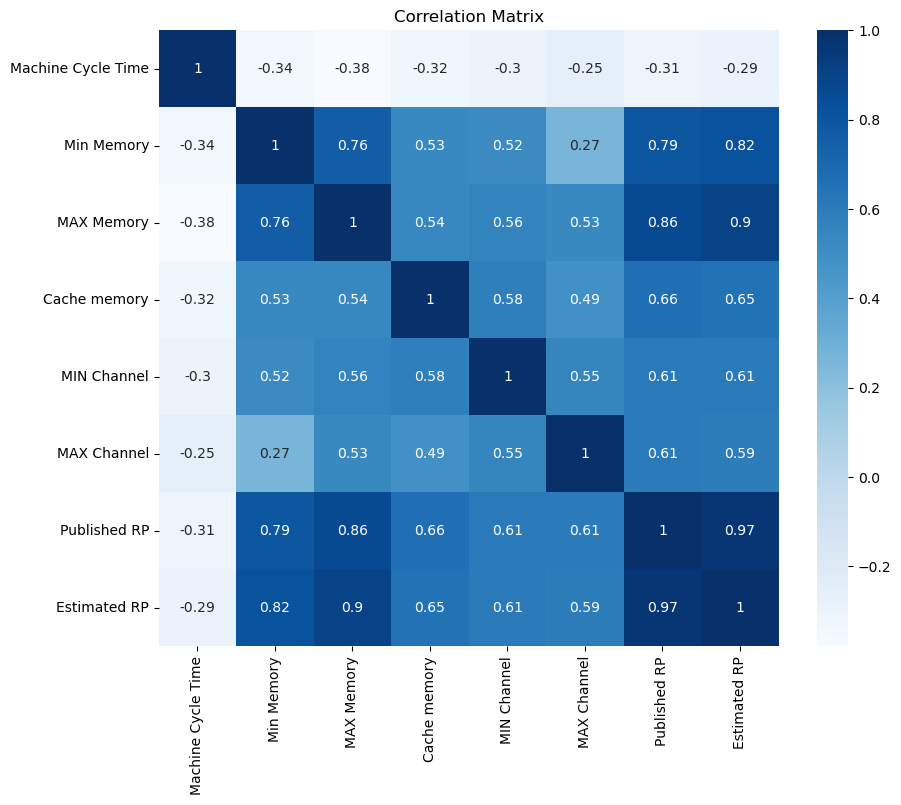

In [289]:
# The correlational analysis can have an effect on the feature selection process because it can help identify 
# which features are highly correlated with the target variable and therefore potentially more important for the model. 
# However, it is important to consider other factors as well, such as the relevance of the features to the problem at hand.
# and the complexity of the model.

# Plotting correlation heat map for our dataset

plt.figure(figsize=(10,8))
plt.title('Correlation Matrix')
sns.heatmap(df.corr(), cmap="Blues", annot=True)         
plt.show()

## Correlational Analysis:
From the correlation matrix, we found that Estimated RP is positively correlated with Min Memory, MAX Memory, Cache Memory , MIN Channel and MAX Channel, so using these features in our training model will improve accuracy of the model.

## 1.3. Data Visualizations

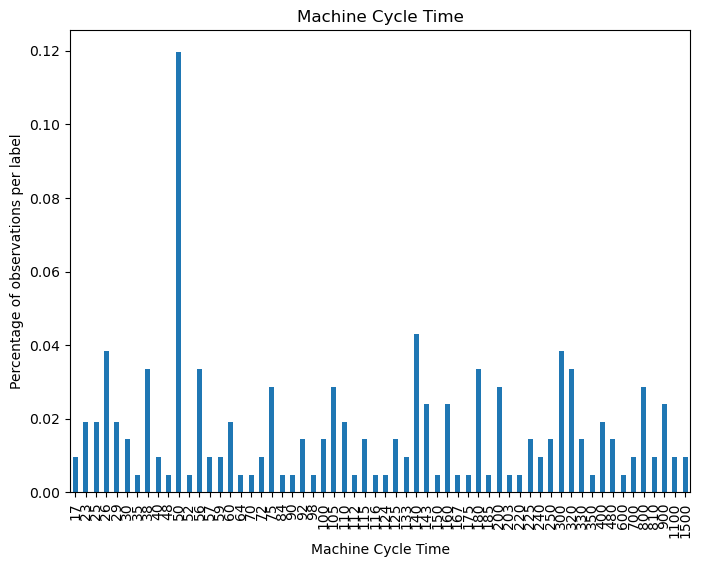

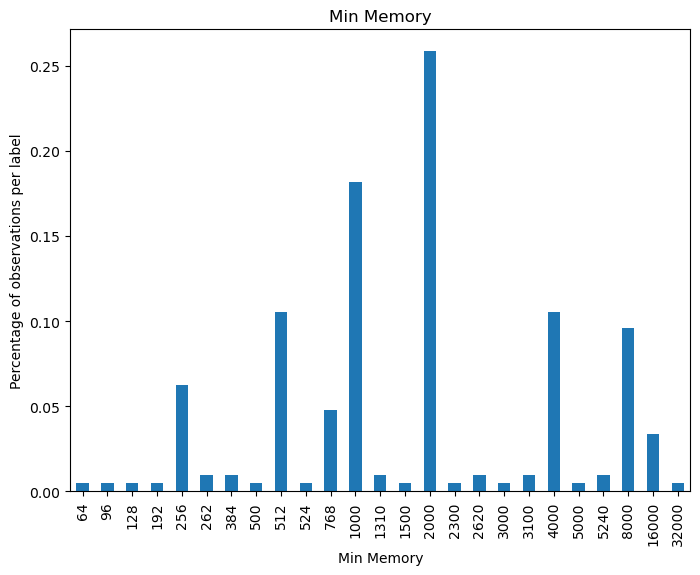

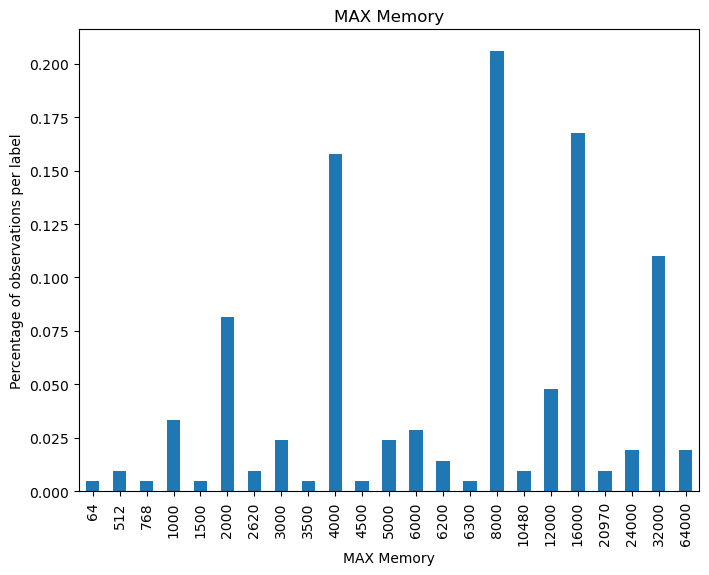

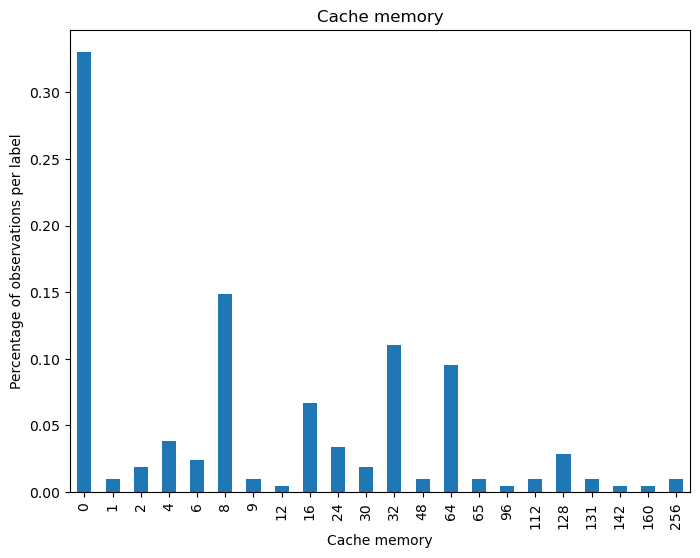

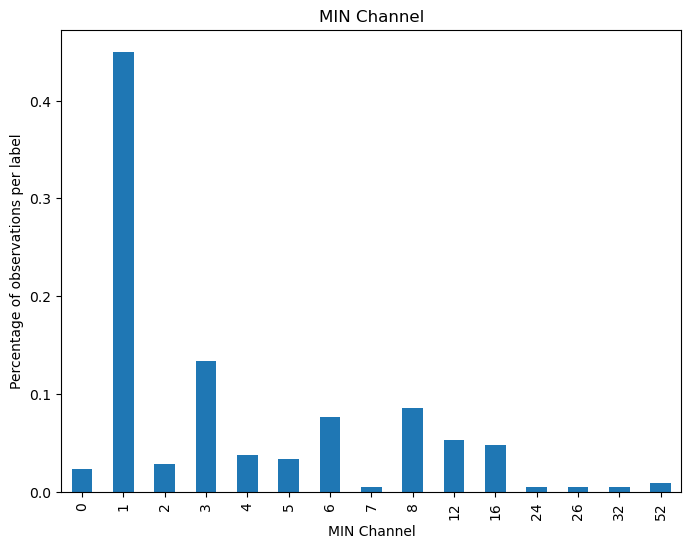

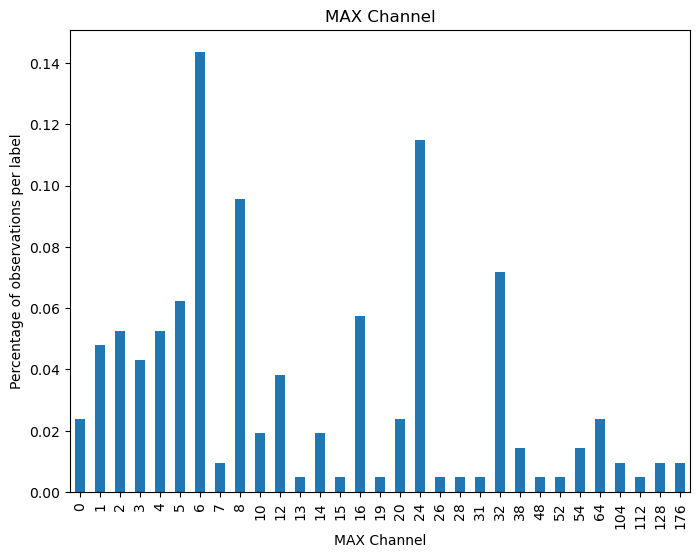

In [290]:
# To detect outliers in discrete variables, we plot Barplot for ['Machine Cycle Time', 'Min Memory', 'MAX Memory', 'Cache memory', 'MIN Channel', 'MAX Channel']

for var in ['Machine Cycle Time', 'Min Memory', 'MAX Memory', 'Cache memory', 'MIN Channel', 'MAX Channel']:
    plt.figure(figsize=(8,6))
    (df.groupby(var)[var].count() / float(len(df))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

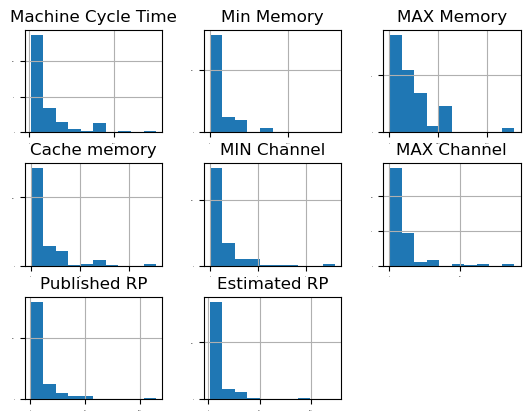

In [291]:
# To get an insight into the dataset, we can use various types of visualizations such as scatter plots, box plots, and histograms. 
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

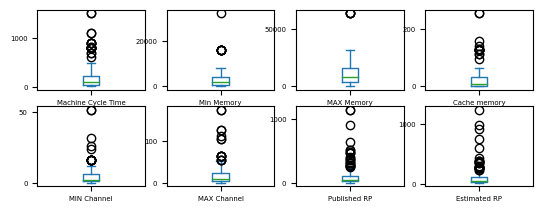

In [292]:
# Visualize Density
df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, legend=False,
fontsize=5)
plt.show()

## Data Cleaning(Removing outliers and Checking NULL/Missing Values)

In [293]:
# Finding the quantile using the DataFrame.quantile() Method

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
out = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
out

Cache memory          15
Estimated RP          24
MAX Channel           15
MAX Memory             4
MIN Channel           15
Machine Cycle Time    20
Min Memory             8
Model Name             0
Published RP          23
Vendor Name            0
dtype: int64

In [294]:
# Handling outliers: This can be done using methods such as capping or truncating extreme values,or using robust scalers to transform the data.  
# In our case we will be removing extreme values this will induce null values in the dataset so we can convert it to zero and drop those rows 
# (for our dataset using robust scalers and transformation causing overfitting to the model) 

mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
#print(mask)
df[mask] = np.nan
df = df.dropna()

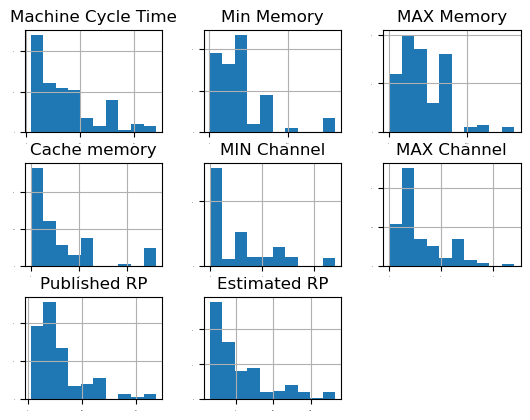

In [295]:
# Plotting histogram after removing outliers
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

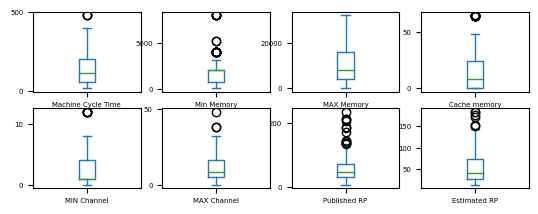

In [296]:
# Box plot after removing outliers
df.plot(kind='box', subplots=True, layout=(4,4), sharex=True, legend=True,
fontsize=5)
plt.show()

In [297]:
df.describe()

,Machine Cycle Time,Min Memory,MAX Memory,Cache memory,MIN Channel,MAX Channel,Published RP,Estimated RP
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,146.429530,1975.328859,8890.899329,14.255034,2.979866,11.093960,59.718121,55.436242
std,108.928271,1787.823146,6269.005225,18.445740,2.795918,8.923354,46.510255,38.805879
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,56.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,29.000000,27.000000
50%,112.000000,2000.000000,8000.000000,8.000000,1.000000,8.000000,45.000000,42.000000
75%,200.000000,2000.000000,16000.000000,24.000000,4.000000,16.000000,71.000000,74.000000
max,480.000000,8000.000000,32000.000000,65.000000,12.000000,48.000000,237.000000,183.000000


In [298]:
# Info summary confirms that there are no missing or NULL values in dataframe as all values are non-null and equal to 209.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 4 to 208
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Vendor Name         149 non-null    object 
 1   Model Name          149 non-null    object 
 2   Machine Cycle Time  149 non-null    float64
 3   Min Memory          149 non-null    float64
 4   MAX Memory          149 non-null    float64
 5   Cache memory        149 non-null    float64
 6   MIN Channel         149 non-null    float64
 7   MAX Channel         149 non-null    float64
 8   Published RP        149 non-null    float64
 9   Estimated RP        149 non-null    float64
dtypes: float64(8), object(2)
memory usage: 12.8+ KB


In [299]:
# seperating the categorical columns from the dataframe
df_cat = [column for column in df.columns if df[column].dtype=='O']
df_cat

['Vendor Name', 'Model Name']

In [300]:
# As from the dataset introduction we got to know there are 30 vendors,
# checking the count of each vendor in the dataframe

df['Vendor Name'].value_counts()

ibm             18
nas             14
siemens         10
ncr              9
sperry           8
honeywell        8
hp               7
harris           7
cdc              7
c.r.d            6
ipl              6
magnuson         6
cambex           5
prime            5
burroughs        5
dg               5
dec              4
perkin-elmer     3
nixdorf          3
wang             2
apollo           2
gould            2
bti              2
basf             2
four-phase       1
sratus           1
amdahl           1
Name: Vendor Name, dtype: int64

In [301]:
# finding out if there are any duplicate model names 
df['Model Name'].duplicated().any()

False

In [302]:
#Seperating numerical columns from the dataframe

df_num = [column for column in df.columns if df[column].dtype!='O']
df_num

['Machine Cycle Time',
 'Min Memory',
 'MAX Memory',
 'Cache memory',
 'MIN Channel',
 'MAX Channel',
 'Published RP',
 'Estimated RP']

In [303]:
# printing top 5 rows of numerical variables
df[df_num].head()

,Machine Cycle Time,Min Memory,MAX Memory,Cache memory,MIN Channel,MAX Channel,Published RP,Estimated RP
4,29.0,8000.0,16000.0,32.0,8.0,16.0,132.0,132.0
10,400.0,1000.0,3000.0,0.0,1.0,2.0,38.0,23.0
11,400.0,512.0,3500.0,4.0,1.0,6.0,40.0,24.0
12,60.0,2000.0,8000.0,65.0,1.0,8.0,92.0,70.0
13,50.0,4000.0,16000.0,65.0,1.0,8.0,138.0,117.0


In [304]:
# As we see in the dataframe we have Published RP and  Estimated RP,
# our aim is to predict the Estimated RP, hence it is the target variable.
# Published RP is a redundant column and can ignored.

In [305]:
# To check outliers in discrete variables
df.describe()

,Machine Cycle Time,Min Memory,MAX Memory,Cache memory,MIN Channel,MAX Channel,Published RP,Estimated RP
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,146.429530,1975.328859,8890.899329,14.255034,2.979866,11.093960,59.718121,55.436242
std,108.928271,1787.823146,6269.005225,18.445740,2.795918,8.923354,46.510255,38.805879
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,56.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,29.000000,27.000000
50%,112.000000,2000.000000,8000.000000,8.000000,1.000000,8.000000,45.000000,42.000000
75%,200.000000,2000.000000,16000.000000,24.000000,4.000000,16.000000,71.000000,74.000000
max,480.000000,8000.000000,32000.000000,65.000000,12.000000,48.000000,237.000000,183.000000


In [306]:
# checking for null values - No Null values present
df.isnull().sum()

Vendor Name           0
Model Name            0
Machine Cycle Time    0
Min Memory            0
MAX Memory            0
Cache memory          0
MIN Channel           0
MAX Channel           0
Published RP          0
Estimated RP          0
dtype: int64

In [307]:
# Splitting the dataset into numerical and categorical dataset
df_categorical = df.iloc[:,:2]

df_categorical.head()

,Vendor Name,Model Name
4,amdahl,470v/7c
10,apollo,dn320
11,apollo,dn420
12,basf,7/65
13,basf,7/68


In [308]:
df_numerical = df.iloc[:, 2:]

df_numerical.head()

,Machine Cycle Time,Min Memory,MAX Memory,Cache memory,MIN Channel,MAX Channel,Published RP,Estimated RP
4,29.0,8000.0,16000.0,32.0,8.0,16.0,132.0,132.0
10,400.0,1000.0,3000.0,0.0,1.0,2.0,38.0,23.0
11,400.0,512.0,3500.0,4.0,1.0,6.0,40.0,24.0
12,60.0,2000.0,8000.0,65.0,1.0,8.0,92.0,70.0
13,50.0,4000.0,16000.0,65.0,1.0,8.0,138.0,117.0


## 3. Modelling Building: Linear Regression

In [309]:
# Selecting the predictor and target variables from df_numerical
# We will ignore Published RP as it is a redundant column

X = df_numerical.iloc[:,0:6]

Y = df_numerical.iloc[:,-1]

## Feature selection

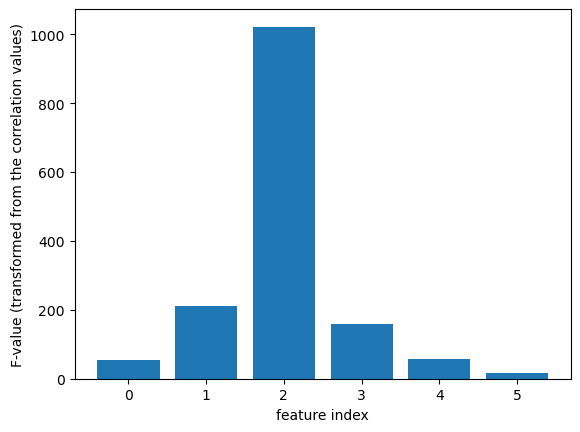

In [310]:
# Feature Selection: This involves selecting a subset of the most relevant or important features for the model.

f_selector = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
f_selector.fit(X, Y)
# transform train input data
X_train_fs = f_selector.transform(X)
# transform test input data
#X_test_fs = f_selector.transform(X_test)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("F-value (transformed from the correlation values)")
plt.show()

In [311]:
X.head()


,Machine Cycle Time,Min Memory,MAX Memory,Cache memory,MIN Channel,MAX Channel
4,29.0,8000.0,16000.0,32.0,8.0,16.0
10,400.0,1000.0,3000.0,0.0,1.0,2.0
11,400.0,512.0,3500.0,4.0,1.0,6.0
12,60.0,2000.0,8000.0,65.0,1.0,8.0
13,50.0,4000.0,16000.0,65.0,1.0,8.0


In [312]:
Y.head()

4     132.0
10     23.0
11     24.0
12     70.0
13    117.0
Name: Estimated RP, dtype: float64

In [313]:
# Splitting data into test and train

from sklearn.model_selection import train_test_split
# For Case 1

X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X,Y,test_size = 0.2,train_size=0.8,random_state = 0)

# For case 2

X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X,Y,test_size = 0.9,train_size=0.1,random_state = 0)

In [314]:
# checking shape of test and training data

X_train_1.shape, Y_train_1.shape

((119, 6), (119,))

In [315]:
X_test_1.shape, Y_test_1.shape

((30, 6), (30,))

## Case 1:Train = 80 % Test = 20%

In [316]:
#For Case 1
#  We will using Feature Scaling method to standardize the data 
# I am using StandardScaler from sklearn for feature

# importing the StandardScaler class from preprocessing library
from sklearn.preprocessing import StandardScaler

# instantiate an object scaler
scaler_1 = StandardScaler()

# fit the scaler to the training set and then transform it
X_train_1 = scaler_1.fit_transform(X_train_1)

# transform the test set
X_test_1 = scaler_1.transform(X_test_1)

In [317]:
# Build and fit the linear regression model

# importing the LinearRegression class from linear_model library
from sklearn.linear_model import LinearRegression

# instantiate an object lr
lr_1 = LinearRegression()


# Train the model using the training sets
lr_1.fit(X_train_1, Y_train_1)

LinearRegression()

In [318]:
# Predicting on the test data set
y_pred_1 = lr_1.predict(X_test_1)
y_pred_1

array([102.36524238,  12.82859186,  29.12724841,  92.93733576,
        19.29491253, 123.42796265,  18.00192128,  27.15595863,
        22.04940343,  44.99862791,  39.16178022,  23.75029386,
        16.10028863,  44.9881833 ,  60.11244291,  53.56795463,
        33.36081835,  34.02615667,  26.853044  ,  32.72314806,
        72.79096766,  30.9660696 ,  84.16164804,  13.70715679,
       152.07370519,  49.62640425,  50.84338411,  42.47391153,
        11.92508613,  77.82927856])

In [319]:
# coefficeints of the trained model
coeff_1 = lr_1.coef_
coeff_1

array([ 1.37709914,  9.78444587, 24.36612166,  9.13472397,  3.86218858,
        0.09307925])

In [320]:
# intercept of the model
intercept_1 = lr_1.intercept_
intercept_1

57.00840336134454

In [321]:
# Building dataframe that contains features and estimated coefficients.

dataset_1_coef = list(zip(X.columns, lr_1.coef_))

pd.DataFrame(data = dataset_1_coef, columns = ['Features','Estimated Coefficients'])


,Features,Estimated Coefficients
0,Machine Cycle Time,1.377099
1,Min Memory,9.784446
2,MAX Memory,24.366122
3,Cache memory,9.134724
4,MIN Channel,3.862189
5,MAX Channel,0.093079


## Case 1: Performance Evaluation

In [322]:
# RMSE(Root Mean Square Error)

from sklearn.metrics import mean_squared_error
mse_1 = mean_squared_error(Y_test_1, y_pred_1)
rmse_1 = np.sqrt(mse_1)
rmse_1

6.225925333135013

In [323]:
# R2 Score
from sklearn.metrics import r2_score

r2_1 = r2_score(Y_test_1, y_pred_1)
r2_1

0.9681867220127276

<b>Analysis for Case 1:<b>
Our R2 score value has been found to be 0.96. It means that this model explains 96%

In [324]:
# Evaluating training set performance

score_training_1 = lr_1.score(X_train_1, Y_train_1)
score_training_1.round(2)

0.98

In [325]:
# Evaluating test set performance

score_test_1 = lr_1.score(X_test_1, Y_test_1)
score_test_1.round(2)

0.97

In [326]:
# import the library
from sklearn.model_selection import cross_val_score

# Compute 5-fold cross-validation scores: cv_scores
cross_val_scores_1 = cross_val_score(lr_1, X, Y, cv=5)


In [327]:
cross_score_1 = mean(absolute(cross_val_scores_1))
cross_score_1

0.962348016410284

In [328]:
cross_val_scores_1.round(2)

array([0.97, 0.93, 0.97, 0.98, 0.96])

In [329]:
print('Mean squared error: ' + str(np.mean((lr_1.predict(X_test_1) - Y_test_1) ** 2)))
print('Variance score: ' + str(lr_1.score(X_test_1, Y_test_1)))

Mean squared error: 38.76214625377232
Variance score: 0.9681867220127276


## Case 2 : Train = 10 % Test = 90%

In [330]:
# checking shape of test and training data for Case 2

X_train_2.shape, Y_train_2.shape

((14, 6), (14,))

In [331]:
X_test_2.shape, Y_test_2.shape

((135, 6), (135,))

In [332]:
# For Case 2

#  We will using Feature Scaling method to standardize the data 
# I am using StandardScaler from sklearn for feature

# importing the StandardScaler class from preprocessing library
from sklearn.preprocessing import StandardScaler

# instantiate an object scaler
scaler_2 = StandardScaler()

# fit the scaler to the training set and then transform it
X_train_2 = scaler_2.fit_transform(X_train_2)

# transform the test set
X_test_2 = scaler_2.transform(X_test_2)

In [333]:
# Build and fit the linear regression model

# importing the LinearRegression class from linear_model library
from sklearn.linear_model import LinearRegression

# instantiate an object lr
lr_2 = LinearRegression()


# Train the model using the training sets
lr_2.fit(X_train_2, Y_train_2)

LinearRegression()

In [334]:
# Predicting on the test data set
y_pred_2 = lr_2.predict(X_test_2)
y_pred_2

array([106.88946513,  14.41090979,  28.93776549,  96.45706627,
        20.62860199, 124.52989116,  23.50104116,  28.19663252,
        25.91741406,  49.36152309,  48.00373385,  27.05092154,
        16.92892819,  49.28298295,  70.43923891,  56.32114088,
        36.23763905,  34.03420935,  33.38009472,  33.03838238,
        77.96988292,  34.17003522,  95.55306477,  15.99407228,
       179.54481861,  53.88620508,  55.9846199 ,  47.73004079,
        14.21943033,  77.60575241,  89.298216  ,  61.07094814,
        61.07094814,  40.37193096,  80.9653378 ,  56.45464335,
       138.10774906,  32.54579338,  73.04484616,  27.51772762,
        48.16222032,  42.00450621,  23.82503983,  51.37624083,
        24.17912087, 131.86065161, 105.26329988,  68.21219417,
        56.60809294,  47.92363375,  25.66977651,  55.40493156,
        59.19624035, 104.81361586,  29.33200777,  52.79414601,
        29.67453411,  69.56121731,  32.54579338,  91.99607883,
        50.52089978,  95.55306477,  24.91702035,  48.23

In [335]:
# coefficeints of the trained model
coeff_2 = lr_2.coef_
coeff_2

array([ 2.24718445,  5.80612179, 43.15892922,  9.18386461,  1.85544628,
        1.01006663])

In [336]:
# intercept of the model
intercept_2 = lr_2.intercept_
intercept_2

60.0

In [337]:
# Building dataframe that contains features and estimated coefficients.

dataset_2_coef = list(zip(X.columns, lr_2.coef_))
pd.DataFrame(data = dataset_2_coef, columns = ['Features', 'Estimated Coefficients'])

,Features,Estimated Coefficients
0,Machine Cycle Time,2.247184
1,Min Memory,5.806122
2,MAX Memory,43.158929
3,Cache memory,9.183865
4,MIN Channel,1.855446
5,MAX Channel,1.010067


## Case 2: Performance Evaluation¶

In [338]:
# RMSE(Root Mean Square Error)

from sklearn.metrics import mean_squared_error
mse_2 = mean_squared_error(Y_test_2, y_pred_2)
rmse_2 = np.sqrt(mse_2)
rmse_2

8.947419192227848

In [339]:
# R2 Score
from sklearn.metrics import r2_score

r2_2 = r2_score(Y_test_2, y_pred_2)
r2_2

0.9406517510907891

<b>Analysis for Case 2:<b>
Our R2 score value has been found to be 0.94. It means that this model explains 94%

In [340]:
# Evaluating training set performance
score_training_2 = lr_2.score(X_train_2, Y_train_2)
score_training_2.round(2)

0.99

In [341]:
# Evaluating test set performance
score_test_2 = lr_2.score(X_test_2, Y_test_2)
score_test_2.round(2)

0.94

Training set and test set performances are comparable. An R Square value of 0.92 is very good.

In [342]:
# Compute 5-fold cross-validation scores: cv_scores
from sklearn.model_selection import cross_val_score
cross_val_scores_2 = cross_val_score(lr_2, X, Y, cv=5)

In [343]:
# Mean absolute score
cross_score_2 = mean(absolute(cross_val_scores_2))
cross_score_2 

0.962348016410284

In [344]:
#cross validation scores
cross_val_scores_2.round(2)

array([0.97, 0.93, 0.97, 0.98, 0.96])

In [345]:
#Mean score for cross validation
avg_score_2 = np.mean(cross_val_scores_2).round(2)
avg_score_2

0.96

In [346]:
print('Mean squared error: ' + str(np.mean((lr_2.predict(X_test_2) - Y_test_2) ** 2)))
print('Variance score: ' + str(lr_2.score(X_test_2, Y_test_2)))

Mean squared error: 80.05631020144729
Variance score: 0.9406517510907891


## Performance metrics table

In [347]:
# Printing performance in table for both cases

p_df = pd.DataFrame()

df1 = {'R2-Score': r2_1, 'RMSE':rmse_1}
df2 = {'R2-Score': r2_2, 'RMSE':rmse_2}
p_df = p_df.append(df1, ignore_index = True)
p_df = p_df.append(df2, ignore_index = True)
p_df.index = ['Case 1','Case 2']
p_df

,R2-Score,RMSE
Case 1,0.968187,6.225925
Case 2,0.940652,8.947419


Text(0.5, 1.0, 'Case 1: Train:80% Test: 20%')

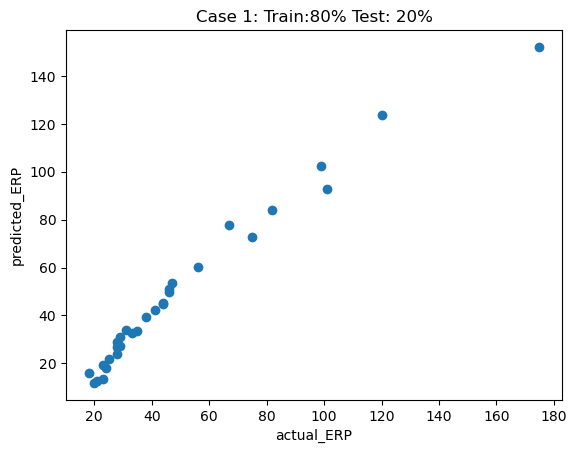

In [352]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted ERP for Case 1

plt.scatter(Y_test_1,y_pred_1)
plt.xlabel('actual_ERP')
plt.ylabel('predicted_ERP')
plt.title("Case 1: Train:80% Test: 20%")

Text(0, 0.5, 'predicted_ERP')

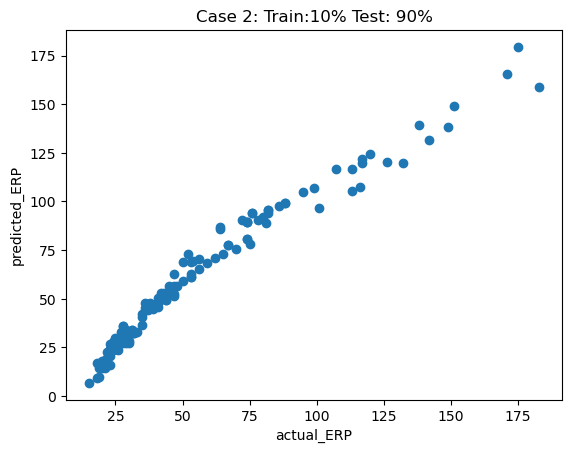

In [353]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted ERP for Case 2

plt.scatter(Y_test_2,y_pred_2)
plt.title("Case 2: Train:10% Test: 90%")
plt.xlabel('actual_ERP')
plt.ylabel('predicted_ERP')

## 4. Prediction for the test data and display the results for the inference. Calculate all the evaluation metrics and choose best for your model.

1. For Case 1: Train = 80 % Test = 20%

R2_score : 0.96

Our R2 score value has been found to be 0.96. It means that this model explains 96% of the variance in our dependent variable.

Mean squared error: 38.76214625377232

Variance score: 0.9681867220127276

In business decisions, the benchmark for the R2 score value is 0.7. It means if R2 score value >= 0.7, then the model is good enough to deploy on unseen data whereas if R2 score value < 0.7, then the model is not good enough to deploy.

2. For Case 2: Train = 10 % Test = 90%

R2 score: 0.94

Our R2 score value has been found to be 0.94. It means that this model explains 94% of the variance in our dependent variable.

Mean squared error: 80.05631020144729

Variance score: 0.9406517510907891

Performance Evaluation: If we compare Case 1 and Case 2, For training set in case 1(Train = 80 % Test = 20%) to case 2 (Train = 10 % Test = 90%), variance score decreased from 96% to 94% and MSE increased from 38.7 to 80.05
hence we can say that Case 1 with training set 80% gives better results than case 2.